# $$\text{WEATHER - SEOUL}$$
### $$\textbf{Analiza danych rzeczywistych przy pomocy modelu ARMA}$$

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## 1. Wstęp

    1.1. Czy w analizowanych danych występują braki?

In [172]:
# data = pd.read_csv('mumbai.csv')
# data['datetime'] = pd.to_datetime(data['datetime'], format="%d-%m-%Y")

In [173]:
data = pd.read_csv('seoul.csv')
data['datetime'] = pd.to_datetime(data['datetime'])
data.isnull().sum()

name                  0
datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          386
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk            9
sunrise               0
sunset                0
moonphase             0
conditions            0
description           0
icon                  0
stations              0
dtype: int64

In [174]:
data.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,seoul,2022-01-01,2.0,-10.2,-4.7,0.3,-15.0,-6.6,-15.2,44.3,...,9.9,5,NaN,2022-01-01T07:46:54,2022-01-01T17:24:04,0.94,Clear,Clear conditions throughout the day.,clear-day,"47098099999,47112099999,47119099999,4712209999..."
1,seoul,2022-01-02,2.6,-4.4,-1.1,-0.5,-8.6,-4.0,-8.4,58.9,...,10.1,5,NaN,2022-01-02T07:47:03,2022-01-02T17:24:52,0.98,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"47111099999,47098099999,47112099999,4711909999..."
2,seoul,2022-01-03,2.2,-7.7,-2.4,0.6,-11.5,-4.7,-10.1,56.4,...,9.8,5,NaN,2022-01-03T07:47:10,2022-01-03T17:25:41,0.00,"Snow, Rain, Partially cloudy",Becoming cloudy in the afternoon with late aft...,rain,"47111099999,47098099999,47112099999,4711909999..."
3,seoul,2022-01-04,1.0,-5.0,-1.9,0.6,-9.1,-4.7,-10.6,54.8,...,10.9,5,NaN,2022-01-04T07:47:15,2022-01-04T17:26:32,0.04,Snow,Clear conditions throughout the day with late ...,rain,"47111099999,47098099999,47112099999,4711909999..."
4,seoul,2022-01-05,1.7,-7.7,-3.1,1.7,-12.0,-4.9,-13.0,46.7,...,6.1,3,NaN,2022-01-05T07:47:18,2022-01-05T17:27:23,0.08,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"47111099999,47098099999,47112099999,4711909999..."


    1.2. Czy badany zbiór danych zawiera informacje ze wszystkich dni z zakresu od 2022-01-01 do 2024-01-01 (tzn. 'równe oddalenie w czasie')?

In [175]:
data_copy = data.copy()

In [176]:
data_copy['datetime'] = pd.to_datetime(data_copy['datetime'])
data_copy.set_index('datetime', inplace=True)
data_copy.sort_index(inplace=True)

In [177]:
full_date_range = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
missing_dates = full_date_range.difference(data_copy.index)
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

Odpowiedź brzmi tak.

    1.3. Wizualizacja danych

In [178]:
data_clean = data[['datetime', 'windspeed']]
data_clean.head()


,datetime,windspeed
0,2022-01-01,8.9
1,2022-01-02,13.0
2,2022-01-03,10.5
3,2022-01-04,13.3
4,2022-01-05,9.0


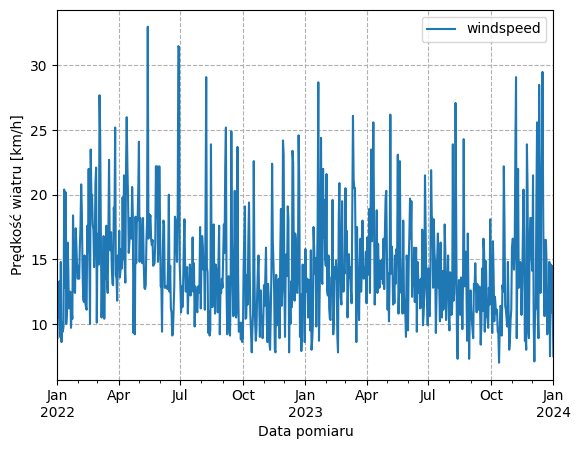

In [179]:
data_clean.plot(x='datetime', y='windspeed')
plt.grid(True, linestyle = '--')
plt.ylabel('Prędkość wiatru [km/h]')
plt.xlabel('Data pomiaru')
plt.show()

## 2. Przygotowanie danych do analizy

    2.1. Jakość danych

- zakres badanych wartości

In [180]:
# minimalna prędkość wiatru
min_wind = np.min(data_clean['windspeed'])
max_wind = np.max(data_clean['windspeed'])

print('Minimalna prędkość wiatru w danych:', min_wind)
print('Maksymalna prędkość wiatru w danych:', max_wind)

Minimalna prędkość wiatru w danych: 7.0
Maksymalna prędkość wiatru w danych: 33.0


- niekompletne dane: NIE

In [181]:
data_clean.isnull().sum()

datetime     0
windspeed    0
dtype: int64

    2.2. Dekompozycja szeregu czasowego

-  wykres ACF oraz PACF dla surowych danych,

In [182]:
windspeed = data_clean['windspeed']
h = 40

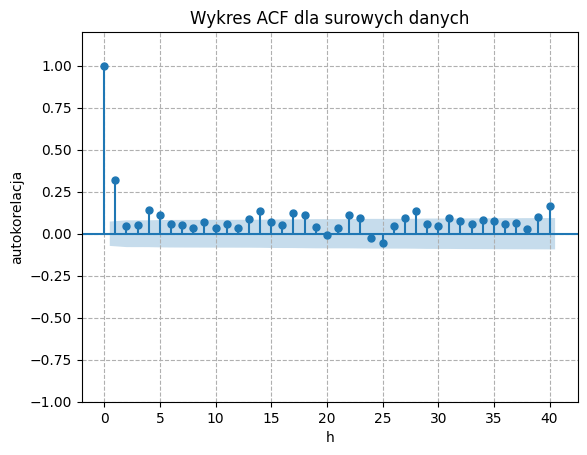

In [183]:
plot_acf(windspeed, lags=h)
plt.title("Wykres ACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('autokorelacja')
plt.ylim(-1,1.2)
plt.show()

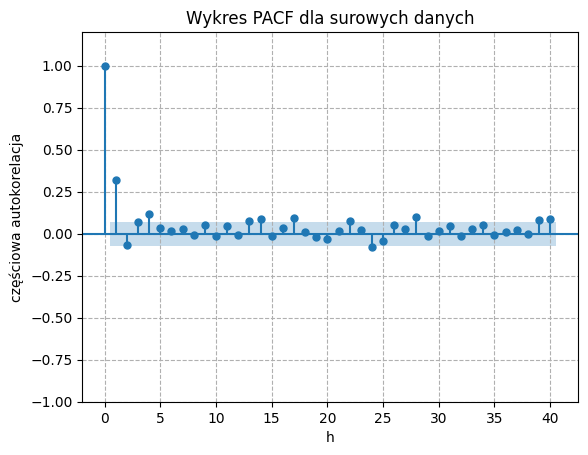

In [184]:
plot_pacf(windspeed, lags=h, method='ywm')
plt.title("Wykres PACF dla surowych danych")
plt.grid(True, linestyle='--')
plt.xlabel('h')
plt.ylabel('częściowa autokorelacja')
plt.ylim(-1,1.2)
plt.show()


    2.3. Identyfikacja trendów deterministycznych

    2.4. Wykres ACF oraz PACF dla uzyskanego szeregu

## 3. Modelowanie danych przy pomocy ARMA

    3.1. Dobranie rzędu modelu (kryteria informacyjne)

    3.2. Estymacja parametrów modelu wybraną metodą.

##  4. Ocena dopasowania modelu

    4.1. Przedziały ufności dla PACF/ACF

    4.2. Porównanie linii kwantylowych z trajektorią

## 5. Weryfikacja założeń dotyczących szumu

    5.1. Założenie dot. średniej (wykres wartości resztowych / t test)

    5.2. Założenie dot. wariancji (wykres wartości resztowych / Modified Levene Test / Arch Test)

    5.3. Założenie dot. niezależności (wykres ACF/PACF dla wartości resztowych / test Ljunga-Boxa)

    5.4. Założenie dot. normalności rozkładu (dystrybuanta / gęstość / wykres kwantylowy / testy na normalność)

## 6. Podsumowanie